# ***Imports***

In [267]:
import glob
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook,tqdm
from PIL import Image
import os
from os import listdir


In [268]:
import tensorflow as tf
from tensorflow.keras import layers,Model,Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Progbar,pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer


# ***Utils***

In [269]:
SHAPE = (64,64)
nb_image = 500
BATCH_SIZE = 128
SEED = 42

In [270]:
# Save a GIF using logged images
def save_gif(img_list, path="", interval=200):
    # Transform images from [-1,1] to [0, 255]
    imgs = []
    for im in img_list:
        im = (im + 1) * 127.5
        im = np.clip(im, 0, 255).astype(np.uint8)
        im = Image.fromarray(im)
        imgs.append(im)
    
    imgs = iter(imgs)

    # Extract first image from iterator
    img = next(imgs)

    # Append the other images and save as GIF
    img.save(fp=path, format='GIF', append_images=imgs,
             save_all=True, duration=interval, loop=0)
    
def save_gif_01(img_list, path="", interval=200):
    # Transform images from [0,1] to [0, 255]
    imgs = []
    for im in img_list:
        im = np.clip(im, 0, 1) * 255
        im = im.astype(np.uint8)
        im = Image.fromarray(im)
        imgs.append(im)

    imgs = iter(imgs)

    # Extract first image from iterator
    img = next(imgs)

    # Append the other images and save as GIF
    img.save(fp=path, format='GIF', append_images=imgs,
             save_all=True, duration=interval, loop=0)


# ***Dataset***

- Emojies datasets

In [271]:
values_location = "values.npy"
targets_location = "targets.npy"


emoji_captions = pd.read_csv("/kaggle/input/emojiimage-dataset/full_emoji.csv")

image_file_apple = "/kaggle/input/emojiimage-dataset/image/Apple/"
image_file_facebook = "/kaggle/input/emojiimage-dataset/image/Facebook"
image_file_google = "/kaggle/input/emojiimage-dataset/image/Google/"
image_file_joypixels = "/kaggle/input/emojiimage-dataset/image/JoyPixels/"
image_file_samsung = "/kaggle/input/emojiimage-dataset/image/Samsung/"
image_file_twitter = "/kaggle/input/emojiimage-dataset/image/Twitter/"
image_file_windows = "/kaggle/input/emojiimage-dataset/image/Windows/"


    # images_apple = np.array(os.listdir(image_file_apple))
    # images_facebook = np.array(os.listdir(image_file_facebook))
    # images_google = np.array(os.listdir(image_file_google))
    # images_joypixels = np.array(os.listdir(image_file_joypixels))
    # images_samsung = np.array(os.listdir(image_file_samsung))
    # images_twitter = np.array(os.listdir(image_file_twitter))
    # images_windows = np.array(os.listdir(image_file_windows))

images_apple = []
images_facebook =[]
images_google = []
images_joypixels = []
images_samsung = []
images_twitter = []
images_windows = []


for i in range(1, nb_image):
    images_apple.append(os.path.join(image_file_apple, str(i) + '.png')) # Replace .jpg with the extension of your images
    images_facebook.append(os.path.join(image_file_facebook, str(i) + '.png')) # Replace .jpg with the extension of your images
    images_google.append(os.path.join(image_file_google, str(i) + '.png')) # Replace .jpg with the extension of your images
    images_joypixels.append(os.path.join(image_file_joypixels, str(i) + '.png')) # Replace .jpg with the extension of your images
    images_samsung.append(os.path.join(image_file_samsung, str(i) + '.png')) # Replace .jpg with the extension of your images
    images_twitter.append(os.path.join(image_file_twitter, str(i) + '.png')) # Replace .jpg with the extension of your images
    images_windows.append(os.path.join(image_file_windows, str(i) + '.png')) # Replace .jpg with the extension of your images


- Human faces

In [272]:
def create_dataset_from(image_1,image_2,image_3,image_4,image_5,image_6,image_7):
    values = []
    target = []
    for i,images in enumerate(zip(image_1,image_2,image_3,image_4,image_5,image_6,image_7) ):
        for im in images : 
            index = int(re.findall('\d+', im)[-1])
            captions = emoji_captions[emoji_captions["#"]==index]['name'].values[0]
            image = cv2.imread(im)
            if type(image) != type(None):
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                resized_image = cv2.resize(image,SHAPE)
                values.append(resized_image)
                target.append(captions)
    
    np.save(values_location,values,allow_pickle=True)
    np.save(targets_location,target,allow_pickle=True)

    return np.array(values),np.array(target)

In [273]:
values,targets = create_dataset_from(
    images_apple,
    images_facebook,
    images_google,
    images_joypixels,
    images_samsung,
    images_twitter,
    images_windows
)

- Showing shapes

In [274]:
values = np.load(values_location,allow_pickle=True)
targets = np.load(targets_location,allow_pickle=True)

print(values.shape)
print(targets.shape)

(3374, 64, 64, 3)
(3374,)


- Showing dataset

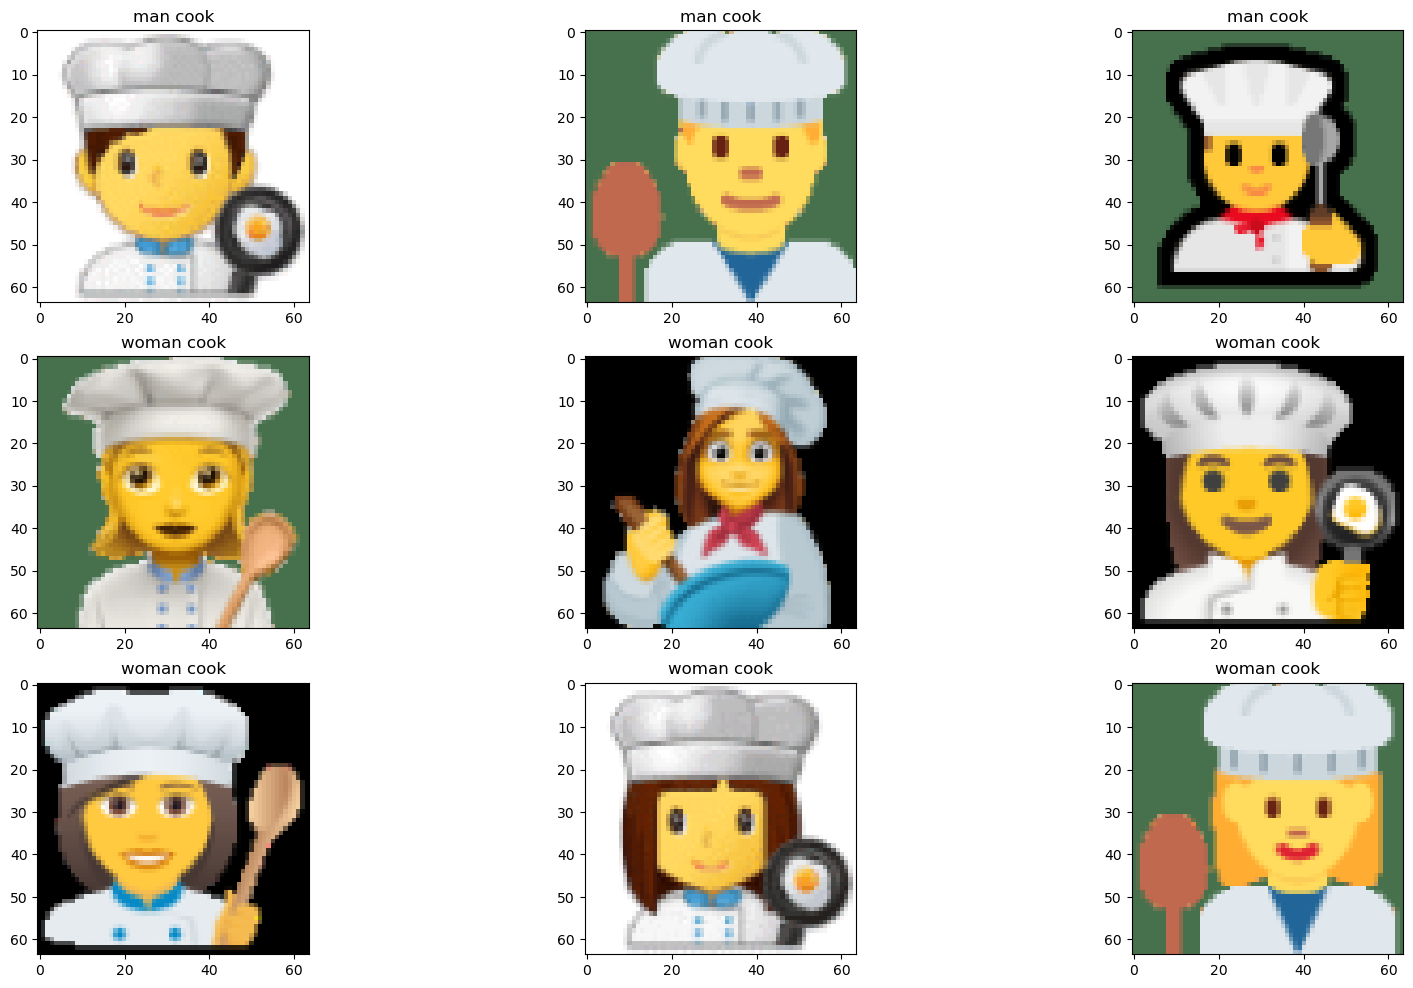

In [275]:
def show_dataset(values,targets):
    born_inf = np.random.randint(0,values.shape[0]-9)
    born_sup = born_inf+9
    
    plt.figure(figsize=(20,12))
    for p,i in enumerate(range(born_inf,born_sup)):
        plt.subplot(3,3,p+1)
        plt.imshow(values[i])
        plt.title(targets[i])
    plt.show()
    
    
    
show_dataset(values,targets)


- Preprocessing

In [276]:
X_train,X_test,y_train,y_test = train_test_split(values,targets,test_size=0.1,random_state=SEED)

In [277]:
def preprocess_text(y,length=64,to_dataset=True):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(y)
    y = tokenizer.texts_to_sequences(y)
    y = pad_sequences(y,maxlen=length,padding='post')
#     y = y.reshape(-1,length)
    if to_dataset : 
        y = tf.convert_to_tensor(y, dtype=tf.float32)
        y = convert_to_dataset(y)
        y = y.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return y 
    
    
def preprocess(x) -> np.ndarray :        
    x = tf.convert_to_tensor(x)
    x = tf.math.divide(x, 255)
    x = x * 2 - 1 
    x = convert_to_dataset(x)
#     x = x.shuffle(SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    # x = np.concatenate(list(x.as_numpy_iterator()))
    x = x.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return x

def convert_to_dataset(x)-> tf.Tensor:
    return tf.data.Dataset.from_tensor_slices(x)




X_train = preprocess(X_train)
y_train = preprocess_text(y_train)

X_test = preprocess(X_test)
y_test = preprocess_text(y_test)

print(len(X_train))
print(len(y_train))

24
24


In [278]:
for i,batchs in enumerate(zip(X_test,y_test)):
    x,y = batchs
    print(x.shape)
    print(y.shape)
    print(y[0])
    break

(128, 64, 64, 3)
(128, 64)
tf.Tensor(
[ 6.  3.  2. 11.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.], shape=(64,), dtype=float32)


# ***Forward Process***

- Adding gaussian noise gradually

In [279]:
timesteps = 300

# create a fixed beta schedule
# beta is the variance
beta = np.linspace(0.0001, 0.02, timesteps)

# this will be used as discussed in the reparameterization trick
# instead of calculating iteratively xt/xt-1 we can find xt/x0

alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)

# this function will help us set the RNG key for Numpy
def set_key(key):
    np.random.seed(key)

# this function will add noise to the input as per the given timestamp
def forward_noise(key, x_0, t):
    set_key(key)
    noise = np.random.normal(size=x_0.shape)
    reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
    noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image, noise

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(key, num):
    set_key(key)
    return tf.random.uniform(shape=[num], minval=0, maxval=timesteps, dtype=tf.int32)

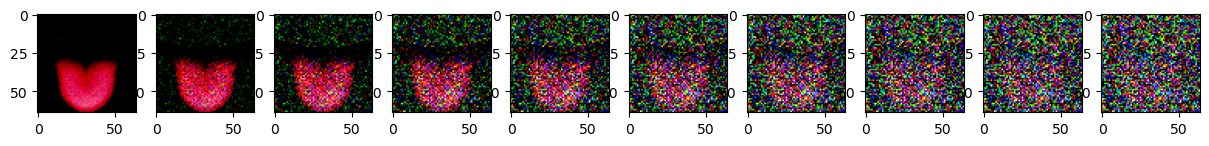

In [280]:
def show_foward_dataset():
    timesteps_range =  np.arange(10,timesteps,30)

    X_train_noise = next(iter(X_train))

    fig = plt.figure(figsize=(15, 30))

    for index, i in enumerate(timesteps_range):
        # expanded_x_train_noise = np.expand_dims(X_train_noise, 0)
        noisy_im, noise = forward_noise(0, X_train_noise, np.array([i,]))
        squeezed_image = np.squeeze(noisy_im)
        plt.subplot(1, len(timesteps_range), index+1)
        plt.imshow(squeezed_image[0,:,:,:],cmap='gray')

    plt.show()

show_foward_dataset()

# ***CNN Model U-NET***

- Unet-block

In [281]:
class BlockUnet(layers.Layer):
    def __init__(self,in_channels,out_channels,time_embedding,side='encoder'):
        super(BlockUnet,self).__init__()
        # specify the current timestep
        self.timestep_mlp = layers.Dense(units=out_channels, input_shape=(time_embedding,))

        if side == 'encoder':
            # downsampling
            self.conv_1 = layers.Conv2D(
                filters=out_channels,
                kernel_size=(3,3),
                padding='same',
                # input_shape=(None, None, 2*in_channels)
            )
            
            self.transform = layers.Conv2D(
                filters=out_channels,
                kernel_size=(4,4),
                strides=(2,2),
                padding='same'
            )
        else:
            # upsampling
            self.conv_1 = layers.Conv2D(
                filters=out_channels,
                kernel_size=(3,3),
                padding='same',
                input_shape=(None, None, 2*in_channels)
            )
            self.transform = layers.Conv2DTranspose(
                filters=out_channels,
                kernel_size=(4,4),
                strides=(2,2),
                padding='same'
            )
            
        self.conv_2 = layers.Conv2D(filters=out_channels,kernel_size=(3,3),padding='same')
        self.bn_1 = layers.BatchNormalization()
        self.bn_2 = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self,X,t):
        h = self.conv_1(X)
        h = self.relu(h)
        h = self.bn_1(h)

        time_embedding = self.timestep_mlp(t)
        time_embedding = self.relu(time_embedding)
        time_embedding = time_embedding[..., None, None, :]

        h += time_embedding

        h = self.conv_2(h)
        h = self.relu(h)
        h = self.bn_2(h)
        h = self.transform(h)
        return h
    

- Unet-sinus-block for calculating time-embedding

In [282]:
class SinusoidalPositionEmbeddings(layers.Layer):
    def __init__(self, dim, max_positions=10000):
        super(SinusoidalPositionEmbeddings, self).__init__()
        self.dim = dim
        self.max_positions = np.array(max_positions,dtype=np.float32)

    def call(self, x, training=True):
        x = tf.cast(x, tf.float32)
        half_dim = self.dim // 2
        emb = tf.math.log(self.max_positions) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = x[:, None] * emb[None, :]

        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)

        return emb

In [283]:
def gelu(x):
    # approximation of gaussien error
    coeff = tf.cast(0.044715, x.dtype)
    return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
   
class GELU(layers.Layer):
    def __init__(self):
        super(GELU, self).__init__()

    def call(self, x, training=True):
        return gelu(x)

- Unet-class

In [284]:
class Unet(Model):
    
    def __init__(self,image_dim,embedding_len):
        super(Unet,self).__init__()
        # time embedding 
        self.dim = SHAPE[0]
        self.image_dim = image_dim

        self.time_embedding_mlp = Sequential([
            SinusoidalPositionEmbeddings(self.dim),
            layers.Dense(self.dim),
            GELU(),
            layers.Dense(self.dim),
# #             layers.ReLU()
        ])

        self.first_conv = layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')
        self.encoders = [
            BlockUnet(64,128,self.dim,side='encoder'),
            BlockUnet(128,256,self.dim,side='encoder'),
            BlockUnet(256,512,self.dim,side='encoder'),
            BlockUnet(512,1024,self.dim,side='encoder'),
        ]
        self.decoders = [
            BlockUnet(1024,512,self.dim,side='decoder'),
            BlockUnet(512,256,self.dim,side='decoder'),
            BlockUnet(256,128,self.dim,side='decoder'),
            BlockUnet(128,64,self.dim,side='decoder'),
        ]
        self.last_conv = layers.Conv2D(filters=self.image_dim,kernel_size=(1,1))
#         self.captions_embedding = layers.Embedding(embedding_len,self.dim)
        
    def call(self,X,y,current_timestep,training=True):
        t = self.time_embedding_mlp(current_timestep)
        if y is not None:
            t+=y
   
        X = self.first_conv(X)
    
        residual_connexion = []

        for encoder in self.encoders:
            X = encoder(X, t)
            residual_connexion.append(X)

        for decoder in self.decoders:
            residual_x = residual_connexion.pop()
            # Add residual x as additional channels
            X = tf.concat([X, residual_x], axis=-1)
            X = decoder(X, t)
        X = self.last_conv(X)
        return X

In [285]:
model = Unet(image_dim=1,embedding_len=64)
opt = Adam(learning_rate=1e-4)

- Loss function

In [286]:
@tf.function
def loss_of(noise,noise_pred):
    noise = tf.cast(noise,dtype=noise_pred.dtype)
    return tf.math.reduce_mean(tf.square(noise-noise_pred))

# ***Training***

- Training-step function

In [287]:
@tf.function
def train_step(timestep_values,noised_image,noise,captions_embedding=None):
    # calculate loss and update parameters
    with tf.GradientTape() as tape:
        prediction = model(noised_image,captions_embedding, timestep_values)
        loss_value = loss_of(noise, prediction)
    gradients = tape.gradient(loss_value, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_value

In [288]:
@tf.function
def validation_step(timestep_values,noised_image,noise,captions_embedding=None):
    # calculate loss and update parameters
    prediction = model(noised_image,captions_embedding, timestep_values,training=False)
    loss_value = loss_of(noise, prediction)
    return loss_value

- Training loop

In [ ]:
EPOCHS = 200
training_loss = []
val_loss = []

for e in tf.range(EPOCHS):
    print(f"epoch  : {e+1}/{EPOCHS}")
    pb_i = Progbar(len(X_train), stateful_metrics=('loss','val_loss'))
    
    batch_loss = []
    for i,batchs in enumerate(zip(X_train,y_train)):
        batch_x,batch_y = batchs
        rng, tsrng = np.random.randint(0, 100000, size=(2,))
        # generate a timestep
        timestep_values = generate_timestamp(tsrng, batch_x.shape[0])
        # generate a noise_image
        noised_image, noise = forward_noise(rng, batch_x, timestep_values)
        # convert parameters to tensor because of @tf.function
        noised_image = tf.convert_to_tensor(noised_image)
        noise = tf.convert_to_tensor(noise)
        timestep_values = tf.constant(timestep_values)        
        # calculate loss and update parameters
        if tf.random.uniform(shape=[1], minval=0, maxval=1, dtype=tf.float32) < 0.1:
            batch_y = None
        loss = train_step(timestep_values,noised_image,noise,batch_y)
        batch_loss.append(loss)
        # showing progress
        values=[('loss',loss)]
        pb_i.add(1, values=values)
        
    val_batch_loss = []
    for batchs in zip(X_test,y_test):
        batch_x,batch_y = batchs
        
        rng, tsrng = np.random.randint(0, 100000, size=(2,))
        # generate a timestep
        timestep_values = generate_timestamp(tsrng, batch_x.shape[0])
        # generate a noise_image
        noised_image, noise = forward_noise(rng, batch_x, timestep_values)
        # convert parameters to tensor because of @tf.function
        noised_image = tf.convert_to_tensor(noised_image)
        noise = tf.convert_to_tensor(noise)
        timestep_values = tf.constant(timestep_values)        
        # calculate loss and update parameters
        if tf.random.uniform(shape=[1], minval=0, maxval=1, dtype=tf.float32) < 0.1:
            batch_y = None
        
        loss = validation_step(timestep_values,noised_image,noise,batch_y)
        val_batch_loss.append(loss)
            
    val_loss.append(sum(val_batch_loss)/len(val_batch_loss))
    training_loss.append(sum(batch_loss)/len(batch_loss))

epoch  : 1/200
24/24 [==============================] - 37s 958ms/step - loss: 1.0175
epoch  : 2/200
24/24 [==============================] - 11s 465ms/step - loss: 1.0052
epoch  : 3/200
24/24 [==============================] - 11s 469ms/step - loss: 0.9975
epoch  : 4/200
24/24 [==============================] - 14s 612ms/step - loss: 0.9571
epoch  : 5/200
24/24 [==============================] - 11s 469ms/step - loss: 0.9325
epoch  : 6/200
24/24 [==============================] - 11s 464ms/step - loss: 0.8804
epoch  : 7/200
24/24 [==============================] - 11s 467ms/step - loss: 0.8368
epoch  : 8/200
24/24 [==============================] - 11s 467ms/step - loss: 0.8020
epoch  : 9/200
24/24 [==============================] - 11s 465ms/step - loss: 0.7827
epoch  : 10/200
24/24 [==============================] - 11s 471ms/step - loss: 0.7729
epoch  : 11/200
24/24 [==============================] - 11s 465ms/step - loss: 0.7762
epoch  : 12/200
24/24 [=============================

- Saving model and creating zip

In [ ]:
model_path = 'diffusion-model'
model.save(model_path)

In [ ]:
!zip -r file.zip 'diffusion-model'

- Evaluation

In [ ]:
for i in range(len(val_loss)):
    if val_loss[i]>1:
        val_loss[i]=1

plt.style.use("ggplot")
plt.figure()
plt.plot(val_loss, label="val_loss")
plt.plot(training_loss, label="train_loss")
plt.title("Results")
plt.xlabel("Epochs #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot.png")
plt.show()


# ***DDPM (Denoising Diffusion Probabilistic Model)***

- Algorithm to denoise

In [ ]:
# algorithm in the paper
def ddpm(x_t, pred_noise, t):
    alpha_t = np.take(alpha, t)
    alpha_t_bar = np.take(alpha_bar, t)

    eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** .5
    mean = (1 / (alpha_t ** .5)) * (x_t - eps_coef * pred_noise)

    var = np.take(beta, t)
    z = np.random.normal(size=x_t.shape)

    return mean + (var ** .5) * z

- Testing

In [ ]:
model_path = 'diffusion-model'
model = load_model(model_path)

# ***Generation test***

In [ ]:
nb_image = 9
nb_dim = 1

def show_result(captions,cfg_scale=3):
    captions = preprocess_text(captions,to_dataset=False)
    captions.astype(np.float32)
    
    plt.figure(figsize=(12,7))
    for k in tqdm_notebook(range(nb_image)):
        # create random noise
        rng = np.random.randint(0, 100000, size=(1,))
        set_key(rng)

        # Generate a tensor with random values using the normal distribution
        x = tf.random.normal(shape=(1, SHAPE[0], SHAPE[1], nb_dim))


        img_list = []
        img_list.append(np.squeeze(x))

        for i in range(timesteps-1):
            t = np.expand_dims(np.array(timesteps-i-1, np.int32), 0)
            # predict noise for an image
            pred_noise = model(x,captions, t)
            if cfg_scale > 0 :
                uncond_predicted_noise = model([x, None, t])
                pred_noise = tf.math.lerp(uncond_predicted_noise, pred_noise, cfg_scale)
            
            if k==0 and i == 0:
                print(model.summary())
            # get the denoised image
            x = ddpm(x, pred_noise, t)
            # add it
            img_list.append(np.squeeze(x))

        plt.subplot(int(np.sqrt(nb_image)),int(np.sqrt(nb_image)),(k+1))
        plt.title(f"Generated emoji {k+1}")
        if gray :
            plt.imshow(np.array(np.clip((x[0] + 1) * 127.5, 0, 255), np.uint8),cmap='gray')
        else: 
            plt.imshow(np.array(np.clip((x[0] + 1) * 127.5, 0, 255), np.uint8))
        # range [0-1]
        # plt.imshow(np.array(np.clip(x[0], 0, 1) * 255, np.uint8)) 
        save_gif_01(img_list + ([img_list[-1]] * 100), f"ddpm_0{k+1}.gif", interval=20)
    #     save_gif(img_list + ([img_list[-1]] * 100), f"ddpm.gif", interval=20)
    plt.show()

show_result(True)

- Generation

In [ ]:
plt.figure()
plt.title("Generated emoji")
# range [0-1]
# plt.imshow(np.array(np.clip(x[0], 0, 1) * 255, np.uint8)) 

plt.imshow(np.array(np.clip((x[0] + 1) * 127.5, 0, 255), np.uint8),cmap='gray')
plt.show()